## Motivation

On Tuesday, September 8th 1857, the steamboat SS Central America left Havana at 9 AM for New York, carrying about 600 passengers and crew members.   Inside of this vessel, there was stowed a very precious cargo: a set of manuscripts by John James Audubon, and three tons of gold bars and coins.  The manuscripts documented an expedition through the yet uncharted southwestern United States and California, and contained 200 sketches and paintings of its wildlife.  The gold, fruit of many years of prospecting and mining during the California Gold Rush, was meant to start anew the lives of many of the passengers aboard.  

On the 9th, the vessel ran into a storm which developed into a hurricane.  The steamboat endured four hard days at sea, and by Saturday morning the ship was doomed.  The captain arranged to have women and children taken off to the brig _Marine_, which offered them assistance at about noon.  In spite of the efforts of the remaining crew and passengers to save the ship, the inevitable happened at about 8 PM that same day.  The wreck claimed the lives of 425 men, and carryied to the bottom of the sea the valuable cargo.

It was not until late 1980s that technology allowed recovery of shipwrecks at deep sea.  But no technology would be of any help without an accurate location of the site.  In the following paragraphs we would like to illustrate the power of the `scipy` stack by performing a simple simulation, that ultimately creates a dataset of possible locations for the wreck of the SS Central America, and mines the data to attempt to pinpoint the most probable target.

We simulate several possible paths of the steamboat (say 10,000 randomly generated possibilities), between 7:00 AM on Saturday, and 13 hours later, at 8:00 pm on Sunday. At 7:00 AM on that Saturday the ship's captain, William Herndon, took a celestial fix and verbally relayed the position to the schooner _El Dorado_.  The fix was 31°25'N, 77°10'W.  Because the ship was not operative at that point---no engine, no sails---, for the next thirteen hours its course was solely subjected to the effect of ocean current and winds.  With enough information, it is possible to model the drift and leeway on different possible paths.

We start by creating a *DataFrame*---a computational structure that will hold all the values we need in a very efficient way.  We do so with the help of the `pandas` libraries.

In [1]:
from datetime import datetime, timedelta
from dateutil.parser import parse

interval = [parse("9/12/1857 7 am")]

for k in range(14*2-1):
    if k % 2 == 0:
        interval.append(interval[-1])
    else:
        interval.append(interval[-1] + timedelta(hours=1)) 	

import numpy as np, pandas as pd

herndon = pd.DataFrame(np.zeros((28, 10000)), index = [interval, ['Lat', 'Lon']*14])

Each column of the dataframe `herndon` is to hold the latitude and longitude of a possible path of the SS Central America, sampled every hour.  For instance, to observe the first path, we issue

In [2]:
print herndon[0]

1857-09-12 07:00:00  Lat    0
                     Lon    0
1857-09-12 08:00:00  Lat    0
                     Lon    0
1857-09-12 09:00:00  Lat    0
                     Lon    0
1857-09-12 10:00:00  Lat    0
                     Lon    0
1857-09-12 11:00:00  Lat    0
                     Lon    0
1857-09-12 12:00:00  Lat    0
                     Lon    0
1857-09-12 13:00:00  Lat    0
                     Lon    0
1857-09-12 14:00:00  Lat    0
                     Lon    0
1857-09-12 15:00:00  Lat    0
                     Lon    0
1857-09-12 16:00:00  Lat    0
                     Lon    0
1857-09-12 17:00:00  Lat    0
                     Lon    0
1857-09-12 18:00:00  Lat    0
                     Lon    0
1857-09-12 19:00:00  Lat    0
                     Lon    0
1857-09-12 20:00:00  Lat    0
                     Lon    0
Name: 0, dtype: float64


Let us populate this data following a similar analysis to the one followed by the Columbus America Discovery Group, as explained by Lawrence D. Stone in the article _Revisiting the SS Central America Search_, from the 2010 Conference on Information Fusion.

The celestial fix obtained by Capt. Herndon at 7:00 AM was taken with a sextant in the middle of a storm.  There are some uncertainties in the estimation of latitude and longitude with this method and under those weather conditions, which are modeled by a bivariate normally distributed random variable with mean `(0,0)` and standard deviations of `0.9` nautical miles (for latitude), and `3.9` nautical miles (for longitude).  We create first a random variable with those characteristics.  Let us use this idea to populate the dataframe with several random initial locations.

In [3]:
from scipy.stats import multivariate_normal

celestial_fix = multivariate_normal(cov = np.diag((0.9, 3.9)))

> To estimate the corresponding celestial fixes, as well as all further geodetic computations, we will use the accurate formulas of Vincenty for ellipsoids, assuming a radius at the Equator of $a = 6378137$ meters, and a flattening of the ellipsoid of $f = 1/298.257223563$ (these figures are regarded as one of the standards for use in cartography, geodesy and navigation, and are referred by the community as the *World Geodetic System WGS-84 ellipsoid*)

> A very good set of formulas coded in `python` can be found at wegener.mechanik.tu-darmstadt.de/GMT-Help/Archiv/att-8710/Geodetic_py.  For a description and theory behind these formulas, read the excellent survey in Wikipedia, en.wikipedia.org/wiki/Vincenty's_formulae.

> In particular, for this example we will be using _Vincenty's direct formula_, that computes the resulting latitude $\phi_2$, longitude $L_2$, and azimuth $s_2$ of an object starting at latitude $\phi_1$, longitude $L_1$, and traveling $s$ meters with initial azimuth $s_1$.  Latitudes, longitudes and azimuths are given in degrees, and distances in meters.  We also use the convention of assigning negative values to the latitudes to the West.  To apply the conversion from nautical miles or knots to their respective units in SI, we employ the system of units in `scipy.constants`.

In [4]:
from Geodetic_py import vinc_pt
from scipy.constants import nautical_mile

a = 6378137.0
f = 1./298.257223563

for k in range(10000):
    lat_delta, lon_delta = celestial_fix.rvs() * nautical_mile
    azimuth = 90 - np.angle(lat_delta + 1j*lon_delta, deg=True)
    distance = np.hypot(lat_delta, lon_delta)
    output = vinc_pt(f, a, 31+25./60, -77-10./60, azimuth, distance)
    herndon.ix['1857-09-12 07:00:00',:][k] = output[0:2]

print herndon.ix['1857-09-12 07:00:00',:]

          0          1          2          3          4          5     \
Lat  31.381341  31.446325  31.408861  31.447792  31.386516  31.427961   
Lon -77.186370 -77.175372 -77.163242 -77.160614 -77.172560 -77.174595   

          6          7          8          9       ...           9990  \
Lat  31.393508  31.395213  31.469795  31.435343    ...      31.438093   
Lon -77.141573 -77.177141 -77.147554 -77.157014    ...     -77.174894   

          9991       9992       9993       9994       9995       9996  \
Lat  31.434899  31.385487  31.402397  31.454387  31.387397  31.441718   
Lon -77.199224 -77.179428 -77.169711 -77.143522 -77.158508 -77.157494   

          9997       9998       9999  
Lat  31.389793  31.362313  31.371069  
Lon -77.186248 -77.163477 -77.196158  

[2 rows x 10000 columns]


We simulate the drift according to the formula $D = (V + \text{leeway} * W)$.  In this formula $V$ (the ocean current) is modeled as vector pointing about North-East (around 45 degrees of azimuth) and a variable speed between 1 and 1.5 knots. The other random variable, $W$, represents the action of the winds in the area during the hurricane, which we choose to represent by directions ranging between South and East, and speeds with a mean 0.2 knots, and standard deviation 1/30 knots. Both random variables are coded as bivariate normal.  Finally, we have accounted for the leeway factor.  According to a study performed on the blueprints of the SS Central America, we have estimated this leeway to be about 3%.

> This choice of random variables to represent the ocean current and wind differs from the ones used in the aforementioned paper.  In our version we have not used the actual covariance matrices as computed by Stone from data received from the Naval Oceanographic Data Center.  Rather, we have presented a very simplified version.  

In [5]:
current = multivariate_normal((np.pi/4, 1.25), cov=np.diag((np.pi/270, .25/3))); \
wind = multivariate_normal((np.pi/4, .3), cov=np.diag((np.pi/12, 1./30))); \
leeway = 3./100

for date in pd.date_range('1857-9-12 08:00:00', periods=13, freq='1h'):
    before  = herndon.ix[date-timedelta(hours=1)]
    for k in range(10000):
        angle, speed = current.rvs()
        current_v = speed * nautical_mile * (np.cos(angle) + 1j * np.sin(angle))
        angle, speed  = wind.rvs()
        wind_v = speed * nautical_mile * (np.cos(angle) + 1j*np.sin(angle))
        drift = current_v + leeway * wind_v 
        azimuth = 90 - np.angle(drift, deg=True)
        distance = abs(drift)
        output = vinc_pt(f, a, before.ix['Lat'][k], before.ix['Lon'][k], azimuth, distance)
        herndon.ix[date,:][k] = output[:2]

Let us plot the first three of those simulated paths:

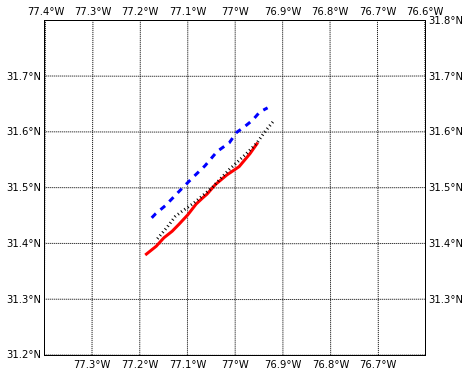

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap 

%matplotlib inline

plt.figure(figsize=(12,6))
m = Basemap(llcrnrlon=-77.4, llcrnrlat=31.2, urcrnrlon=-76.6, 
            urcrnrlat=31.8, projection='lcc', lat_0 = 31.5,
            lon_0=-77, resolution='l', area_thresh=1000.)

m.drawmeridians(np.arange(-77.4,-76.6,0.1), labels=[0,0,1,1])
m.drawparallels(np.arange(31.2,32.8,0.1), labels=[1,1,0,0])
m.drawmapboundary()

colors = ['r', 'b', 'k']
styles = ['-', '--', ':']

for k in range(3):
    latitudes = herndon[k][:,'Lat'].values
    longitudes = herndon[k][:,'Lon'].values
    longitudes, latitudes = m(longitudes, latitudes)
    m.plot(longitudes, latitudes, color=colors[k], lw=3, ls=styles[k])

plt.show() 

This presents us with these three possible paths followed by the SS Central America during its drift in the storm.  As expected they observe a North-Easterly general direction, in occasion showing deviations from the effect of the strong winds. 

The focus of this simulation is, nonetheless, on the final location of all these paths.  Let us plot them all on the same map first, for a quick visual evaluation.

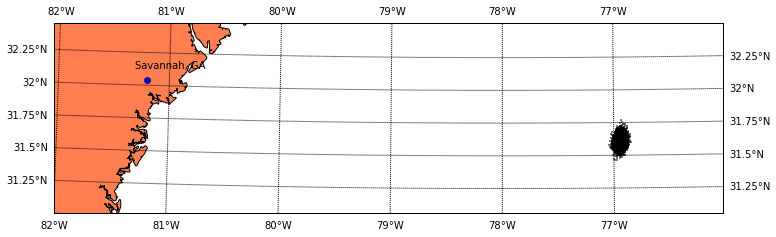

In [8]:
latitudes, longitudes = herndon.ix['1857-9-12 20:00:00'].values

plt.figure(figsize=(12,6))
m = Basemap(llcrnrlon=-82., llcrnrlat=31, urcrnrlon=-76,
            urcrnrlat=32.5, projection='lcc', lat_0 = 31.5, 
            lon_0=-78, resolution='h', area_thresh=1000.)

X, Y = m(longitudes, latitudes)
x, y = m(-81.2003759, 32.0405369)  # Coordinates of Savannah, GA

m.plot(X, Y, 'ko', markersize=1)
m.plot(x,y,'bo')
plt.text(x-10000, y+10000, 'Savannah, GA')
m.drawmeridians(np.arange(-82,-76,1), labels=[1,1,1,1])
m.drawparallels(np.arange(31,32.5,0.25), labels=[1,1,0,0])
m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color='coral')
m.drawmapboundary()
plt.show()

To obtain a better estimate of the true location of the shipwreck, it is possible to expand the simulation by using the information from Captain Johnson of the Norwegian bark _Ellen_.  This ship rescued several survivors at 8 am on Sunday, at a recorded position of 31°55'N, 76°13'W.  We may employ a similar technique to trace back the location where the ship sunk using a _reverse drif_.  For this case, the uncertainty in the celestial fix is modeled by a bivariate normal distribution with standard deviations of 0.9 (latitude) and 5.4 nautical miles (longitude).

> A third simulation is also possible, using the information from the _El Dorado_, but we do not factor this in our computations.

Since at this point the only relevant information is the location of the wreck, we do not need to keep the intermediate locations in our simulated paths.  We record our data in a `panda` *Series* instead:

In [9]:
interval = []

for k in range(10000):
    interval.append(k)
    interval.append(k)

ellen = pd.Series(index = [interval, ['Lat','Lon']*10000])
celestial_fix = multivariate_normal(cov = np.diag((0.9, 5.4)))
current = multivariate_normal((225, 1.25), cov=np.diag((2./3, .25/3)))

for k in range(10000):
    lat_delta, lon_delta = celestial_fix.rvs() * nautical_mile
    azimuth = 90 - np.angle(lat_delta + 1j*lon_delta, deg=True)
    distance = np.hypot(lat_delta, lon_delta)
    output = vinc_pt(f, a, 31+55./60, -76-13./60, azimuth, distance)
    ellen[k] = output[0:2]

for date in pd.date_range('1857-9-13 07:00:00', periods=12, freq='-1h'):
    for k in range(10000):
        angle, speed = current.rvs()
        output = vinc_pt(f, a, ellen[k,'Lat'], ellen[k,'Lon'], 90-angle, speed)
        ellen[k]=output[0:2]

The purpose of the simulation is the construction of a map that indicates the probability of finding the shipwreck depending on latitude and longitude.  We can construct it by performing a *kernel density estimation* on the simulated data.  The difficulty in this case rests in using the correct metric.  Unfortunately, we are not able to create a metric based upon Vincenty's formulas in `scipy` suitable for this operation.  Instead, we have two options:

* a _linear approximation_ in a small area, using the routine `gaussian_kde` from the library `scipy.stats`, or
* a _spherical approximation_, using the class `KernelDensity` from the toolkit `scikit-learn`, imposing a Harvesine metric, and a *ball tree* algorithm.

The advantage of the first method is that it is faster, and the computations for optimal bandwidth are done internally.  The second method is more accurate if we are able to provide the correct bandwidth.  In any case, we prepare the data in the same way, by using the simulation as _training data_.

In [10]:
training_latitudes, training_longitudes = herndon.ix['1857-9-12 20:00:00'].values
training_latitudes = np.concatenate((training_latitudes, ellen[:,'Lat']))
training_longitudes = np.concatenate((training_longitudes, ellen[:,'Lon']))
values = np.vstack([training_latitudes, training_longitudes]) * np.pi/180.

For the linear approximation, we perform the following computations:


In [11]:
from scipy.stats import gaussian_kde

kernel_scipy = gaussian_kde(values)

For the spherical approximation, and assuming a maybe-not-optimal bandwidth `1.e-7`, we issue instead


In [12]:
from sklearn.neighbors import KernelDensity

kernel_sklearn = KernelDensity(metric='haversine', bandwidth=1.e-7, kernel='gaussian', algorithm='ball_tree')
kernel_sklearn.fit(values.T)

KernelDensity(algorithm='ball_tree', atol=0, bandwidth=1e-07,
       breadth_first=True, kernel='gaussian', leaf_size=40,
       metric='haversine', metric_params=None, rtol=0)

From here, all we need to do is generate a map, construct a grid on it, and project on these values the corresponding evaluation of the computed kernel.  This will give us a _probability density function_ (*PDF*) of the corresponding distribution.

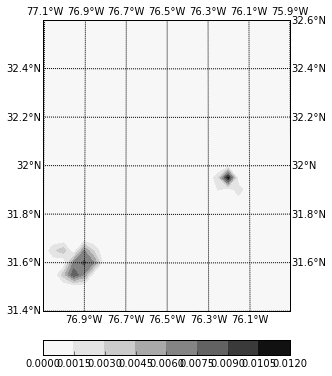

In [15]:
plt.figure(figsize=(12,6))
m = Basemap(llcrnrlon=-77.1, llcrnrlat=31.4, urcrnrlon=-75.9,
            urcrnrlat=32.6, projection='lcc', lat_0 = 32,
            lon_0=-76.5, resolution='l', area_thresh=1000.)
m.drawmeridians(np.arange(-77.5,-75.5,0.2), labels=[0,0,1,1])
m.drawparallels(np.arange(31,33,0.2), labels=[1,1,0,0])
grid_lon, grid_lat = m.makegrid(25, 25)
xy = np.vstack([grid_lat.ravel(), grid_lon.ravel()]) * np.pi/180.

data = kernel_scipy(xy)
data = np.exp(kernel_sklearn.score_samples(xy.T))

levels = np.linspace(data.min(), data.max(), 6)
data = data.reshape(grid_lon.shape)

grid_lon, grid_lat = m(grid_lon, grid_lat)
cs = m.contourf(grid_lon, grid_lat, data, clevels=levels, cmap=plt.cm.Greys)
cbar = m.colorbar(cs, location='bottom', pad="10%")
plt.show()

This presents us with a region of roughly 50 by 50 (nautical miles), colored by the corresponding density. Darker regions indicate higher probability of finding the shipwreck.